[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilya16/isp-tts/blob/main/notebooks/training.ipynb)

# Setup

Before running the code in Colab: switch the Runtime to GPU

Run two cells below once to download dataset, models and install packages.

In [1]:
#@title Download models and code

import os
import IPython.display as ipd

INDEX_ID = "1ejkNbKM5k11ALiXoS_qYbb01O1s2JVpq"
INDEX_FILE = "/content/index.txt"

!gdown {INDEX_ID} -O {INDEX_FILE}

FILE_INDEX = {}
with open(INDEX_FILE, 'r') as f:
    for line in f:
        gid, name = line.strip().split('\t')
        FILE_INDEX[name] = gid

for name, gid in FILE_INDEX.items():
    path = os.path.join("/content", name)
    if not os.path.exists(path):
        !gdown {gid} -O {path}

if os.path.exists("/content/dataset.tar.gz"):
    !tar -xzvf /content/dataset.tar.gz

!git clone https://github.com/ilya16/isp-tts

ipd.clear_output()
print('Successfully downloaded data and code')

Successfully downloaded data and code


In [2]:
#@title Install dependencies
!pip install -r /content/isp-tts/requirements.txt
!apt-get install espeak-ng

ipd.clear_output()
print('Installed required Python libraries')

Installed required Python libraries


# Initialization

Start from here after loading data and installing packages.

In [1]:
#@title Imports
from __future__ import annotations
import os
import sys
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd

CONTENT_DIR = "/content" # @param {type:"string"}

os.chdir(CONTENT_DIR)
sys.path.append(os.path.join(CONTENT_DIR, 'isp-tts'))

os.environ['OMP_NUM_THREADS'] = '1'

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ipd.clear_output()

# Dataset

The dataset should have the following structure:

```
DATASET_ROOT
  wavs
    audio_1.wav
    audio_2.wav
    ...
    audio_N.wav
  meta.csv
  (meta_train.csv) – can be computed below
  (meta_val.csv) – can be computed below
```

The metadata files should have the following structure:

```
wavs/audio_1.wav|This is the sample text.
wavs/audio_2.wav|The second audio св+язяно с +этим т+екстом.
...
wavs/audio_N.wav|нижний текст.
```

In other words, the metadata files should contain the "|"-separated paths to audios (relative to the dataset root) and matched texts.


In [2]:
#@title Dataset root

#@markdown Change the path to your dataset here
DATASET_ROOT = "/content/dataset" # @param {type:"string"}

## Split metadata into train and validation:

Use the cell below to split your metadata into training and validation sets

In [3]:
#@title Split Data

SPLIT_DATA = True # @param {"type":"boolean"}
META_NAME = "meta.csv" # @param {"type":"string","placeholder":"meta.csv"}
RANDOM_SEED = 42 # @param {"type":"integer"}
VAL_RATIO = 0.1 # @param {"type":"number","placeholder":"0.1"}


def load_meta(filename, split="|"):
    with open(filename, encoding='utf-8') as f:
        meta = [line.strip().split(split) for line in f]
    return meta


def split_meta(meta_name, val_size: float = 0.1, seed: int = 42):
    meta_path = os.path.join(DATASET_ROOT, meta_name)
    meta = load_meta(meta_path)

    ids = np.arange(len(meta))

    np.random.seed(seed)
    np.random.shuffle(ids)
    ids = set(np.sort(ids[:int((1 - val_size) * len(meta))]))

    meta_train = []
    for i, x in enumerate(meta):
        if i in ids:
            meta_train.append(x)

    meta_valid = []
    for i, x in enumerate(meta):
        if i not in ids:
            meta_valid.append(x)

    train_meta_path = os.path.join(DATASET_ROOT, meta_name.replace(".csv", "_train.csv"))
    with open(train_meta_path, "w", encoding="utf-8") as f:
        f.writelines(['|'.join(item) + '\n' for item in meta_train])

    valid_meta_path = os.path.join(DATASET_ROOT, meta_name.replace(".csv", "_valid.csv"))
    with open(valid_meta_path, "w", encoding="utf-8") as f:
        f.writelines(['|'.join(item) + '\n' for item in meta_valid])

    print(f"Split metadata `{meta_path}` ({len(meta)} samples) into:"
          f"\n\ttrain: `{train_meta_path}` ({len(meta_train)} samples)"
          f"\n\tvalid: `{valid_meta_path}` ({len(meta_valid)} samples)")


if SPLIT_DATA:
    split_meta(META_NAME, VAL_RATIO, RANDOM_SEED)

Split metadata `/content/dataset/meta.csv` (318 samples) into:
	train: `/content/dataset/meta_train.csv` (286 samples)
	valid: `/content/dataset/meta_valid.csv` (32 samples)


# Training

The are two options to run the training:
1. directly in the notebook by initializing the model, dataset, and trainer
2. using the `train.py` script


Before the training, you need to complete the training conifguration file. The example files for training in Colab are provided in:
- for training an English-only model: `isp-tts/recipes/colab/train_en_ipa.yaml`
- for training a Russian or multi-language model: `isp-tts/recipes/colab/train_ru_en.yaml`

Modify the following arguments in the selected/copied dataset specific to your data:
```yaml
_general_:
  _dirname_: /content/results  # directory where all logs and checkpoints will be stored
  _label_: voice_ru_en  # name for the experiment
```

```yaml
dataset:
  root: /content/dataset  # path to your dataset

  _train_:
    meta_name: meta_train.csv  # training metadata path relative to the dataset root

  _eval_:
    meta_name: meta_valid.csv  # validation metadata path relative to the dataset root
```

Also, you are free to tune the training parameters in the `trainer` section:
```yaml
trainer:
  epochs: 50
  batch_size: 24  # enough for T4 GPU
  eval_batch_size: 48

  eval_strategy: steps
  eval_steps: 50

  project_name: isp-tts  # wandb project name
  accelerator:
    log_with: [tensorboard]
#    log_with: [wandb, tensorboard]  # change to this to store logs in wandb
```

## Training in the notebook

In [4]:
#@title Initilize Experiment Modules
from tts.experiments.modules import ExperimentModules
from tts.experiments import Trainer

CONFIG_ROOT = "/content/isp-tts/recipes" # @param {"type":"string"}
CONFIG_NAME = "colab/train_ru_en.yaml" # @param {"type":"string"}

exp_modules = ExperimentModules(
    config=CONFIG_NAME,
    config_root=CONFIG_ROOT
)
modules = exp_modules.init_modules()
print(modules.keys())

2025-01-27 19:47:07.729 | DEBUG    | tts.data.dataset:__init__:83 - text_length_limits: 286 samples


  0%|          | 0/286 [00:00<?, ?it/s]

2025-01-27 19:47:07.786 | DEBUG    | tts.data.dataset:__init__:87 - audio_length_limits: 286 samples
2025-01-27 19:47:07.800 | DEBUG    | tts.data.dataset:__init__:83 - text_length_limits: 32 samples


  0%|          | 0/32 [00:00<?, ?it/s]

2025-01-27 19:47:07.826 | DEBUG    | tts.data.dataset:__init__:87 - audio_length_limits: 32 samples


dict_keys(['model', 'criterion', 'train_dataset', 'eval_dataset', 'collator', 'evaluator'])


In [5]:
#@title Inspect the datasets

print(f"Training dataset: {len(modules['train_dataset'])} samples")
print(modules["train_dataset"].meta[:5])
print()
print(f"Validation dataset: {len(modules['eval_dataset'])} samples")
print(modules["eval_dataset"].meta[:5])

Training dataset: 286 samples
[('wavs/AXxnsJaFCic_12_1_short_1.wav', 'but while he may make gains on the battlefield.')
 ('wavs/AXxnsJaFCic_12_1_short_2.wav', "he'll pay a continuing high price over the long run.")
 ('wavs/AXxnsJaFCic_12_2_short_1.wav', 'that they will not tolerate anyone.')
 ('wavs/AXxnsJaFCic_12_2_short_2.wav', 'who tries to take their country backwards.')
 ('wavs/AXxnsJaFCic_12_3_short.wav', "and i'm taking robust action to make sure the pain of our sanctions is targeted at russian economy.")]

Validation dataset: 32 samples
[('wavs/AXxnsJaFCic_24_2_short_2.wav', "you'll find a thousand empty acres of land.")
 ('wavs/AXxnsJaFCic_24_2_short_3.wav', "it won't look like much.")
 ('wavs/AXxnsJaFCic_46_1_long.wav', 'my plan will not only lower costs to give families a fair shot, it will lower the deficit. the previous administration not only ballooned the deficit with those tax cuts for the very wealthy and corporations.')
 ('wavs/AXxnsJaFCic_48_long.wav', "the only pres

In [6]:
#@title Initialize the Trainer

trainer = Trainer(
    **modules,
    config=exp_modules.config
)

2025-01-27 19:47:26 INFO    - Initialized output directory: /content/results/AcousticModel/25-01-27/voice_ru_en
2025-01-27 19:47:26 INFO    - Initialized logs directory: /content/results/AcousticModel/25-01-27/voice_ru_en/logs
[<tts.experiments.callbacks.DefaultFlowCallback object at 0x7f0094746090>, <tts.experiments.callbacks.EpochReproducibilityCallback object at 0x7f0096a01550>]
2025-01-27 19:47:26 INFO    - Built CallbackHandler
2025-01-27 19:47:29 INFO    - Built TrackerCallback
2025-01-27 19:47:29 INFO    - Built Training DataLoader
2025-01-27 19:47:29 INFO    - Built Evaluation DataLoader
2025-01-27 19:47:34 WARNING - The following params are incompatible with the ExponentialLR constructor, so they will be ignored: ['total_steps'].
2025-01-27 19:47:34 INFO    - Built Optimizer
2025-01-27 19:47:34 INFO    - Built Trainer!


In [7]:
#@title Run Training

trainer.train()

2025-01-27 19:47:52 INFO    - *** Loading checkpoint ***
2025-01-27 19:47:52 INFO    - Checkpoint path: `/content/acoustic_ru_en.pt`
2025-01-27 19:47:52 INFO    - Warm start is enabled.
2025-01-27 19:47:52 WARNING - The following checkpoint keys are not presented in the model and will be ignored: ['speaker_embedding.weight']
2025-01-27 19:47:52 INFO    - Automatically found the checkpoint keys incompatible with the model: []
2025-01-27 19:47:52 INFO    - Loaded checkpoint `/content/acoustic_ru_en.pt`.
2025-01-27 19:47:52 INFO    - The model graph has been frozen, except for the following parameters: ['aligner.attention.key_proj.0.conv.weight', 'aligner.attention.key_proj.0.norm.weight', 'aligner.attention.key_proj.0.norm.bias', 'aligner.attention.key_proj.1.conv.weight', 'aligner.attention.query_proj.0.conv.weight', 'aligner.attention.query_proj.0.norm.weight', 'aligner.attention.query_proj.0.norm.bias', 'aligner.attention.query_proj.1.conv.weight', 'aligner.attention.query_proj.1.norm

  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:47:57 INFO    - [EVAL]  epoch:   0/ 50 (step: 0), loss: 4.78611
2025-01-27 19:47:57 INFO    - {'loss': 4.78611, 'loss/model/mel_loss': 1.08043, 'loss/adaptor/flow_loss': 1.15571, 'loss/aligner/attention_loss': 2.00287, 'loss/aligner/kl_loss': 0.54709, 'metrics/mcd_13': 35.96825, 'metrics/alignment_length': 2.02481, 'metrics/alignment_strength': 0.81073}
2025-01-27 19:47:57 DEBUG   - Set random seed to 23


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:48:12 INFO    - [TRAIN] epoch:   1/ 50 (step: 12), loss: 5.35650
2025-01-27 19:48:12 INFO    - {'loss': 5.3565, 'loss/model/mel_loss': 1.04806, 'loss/adaptor/flow_loss': 1.10901, 'loss/aligner/attention_loss': 2.28519, 'loss/aligner/kl_loss': 0.91424, 'metrics/mcd_13': 35.72016, 'metrics/alignment_length': 3.38464, 'metrics/alignment_strength': 0.76054}
2025-01-27 19:48:12 DEBUG   - Set random seed to 46


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:48:28 INFO    - [TRAIN] epoch:   2/ 50 (step: 24), loss: 4.53371
2025-01-27 19:48:28 INFO    - {'loss': 4.53371, 'loss/model/mel_loss': 0.7577, 'loss/adaptor/flow_loss': 0.80446, 'loss/aligner/attention_loss': 2.14326, 'loss/aligner/kl_loss': 0.82828, 'metrics/mcd_13': 30.07091, 'metrics/alignment_length': 3.26534, 'metrics/alignment_strength': 0.76856}
2025-01-27 19:48:28 DEBUG   - Set random seed to 69


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:48:42 INFO    - [TRAIN] epoch:   3/ 50 (step: 36), loss: 4.27127
2025-01-27 19:48:42 INFO    - {'loss': 4.27127, 'loss/model/mel_loss': 0.67156, 'loss/adaptor/flow_loss': 0.73393, 'loss/aligner/attention_loss': 2.07784, 'loss/aligner/kl_loss': 0.78794, 'metrics/mcd_13': 27.79524, 'metrics/alignment_length': 3.14495, 'metrics/alignment_strength': 0.77681}
2025-01-27 19:48:42 DEBUG   - Set random seed to 92


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:48:58 INFO    - [TRAIN] epoch:   4/ 50 (step: 48), loss: 4.18132
2025-01-27 19:48:58 INFO    - {'loss': 4.18132, 'loss/model/mel_loss': 0.62661, 'loss/adaptor/flow_loss': 0.75237, 'loss/aligner/attention_loss': 2.04047, 'loss/aligner/kl_loss': 0.76187, 'metrics/mcd_13': 26.63399, 'metrics/alignment_length': 3.13049, 'metrics/alignment_strength': 0.77641}
2025-01-27 19:48:58 DEBUG   - Set random seed to 115


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:49:02 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:49:06 INFO    - [EVAL]  epoch:   4/ 50 (step: 50), loss: 3.40280
2025-01-27 19:49:06 INFO    - {'loss': 3.4028, 'loss/model/mel_loss': 0.54106, 'loss/adaptor/flow_loss': 0.62801, 'loss/aligner/attention_loss': 1.79379, 'loss/aligner/kl_loss': 0.43994, 'metrics/mcd_13': 24.79945, 'metrics/alignment_length': 1.81754, 'metrics/alignment_strength': 0.82977}
2025-01-27 19:49:06 INFO    - Metric improvement on evaluation set (loss: 3.40280)
2025-01-27 19:49:06 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s50.pt ***
2025-01-27 19:49:15 INFO    - [TRAIN] epoch:   5/ 50 (step: 60), loss: 4.09254
2025-01-27 19:49:15 INFO    - {'loss': 4.09254, 'loss/model/mel_loss': 0.60236, 'loss/adaptor/flow_loss': 0.71518, 'loss/aligner/attention_loss': 2.02184, 'loss/aligner/kl_loss': 0.75316, 'metrics/mcd_13': 25.86931, 'metrics/alignment_length': 3.06122, 'metrics/alignment_strength': 0.77704}
2025-01-27 19:49:15 DEBUG   - Set random seed to 1

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:49:28 INFO    - [TRAIN] epoch:   6/ 50 (step: 72), loss: 3.99974
2025-01-27 19:49:28 INFO    - {'loss': 3.99974, 'loss/model/mel_loss': 0.5782, 'loss/adaptor/flow_loss': 0.71232, 'loss/aligner/attention_loss': 1.98744, 'loss/aligner/kl_loss': 0.72178, 'metrics/mcd_13': 25.27956, 'metrics/alignment_length': 2.95155, 'metrics/alignment_strength': 0.77687}
2025-01-27 19:49:28 DEBUG   - Set random seed to 161


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:49:41 INFO    - [TRAIN] epoch:   7/ 50 (step: 84), loss: 3.96337
2025-01-27 19:49:41 INFO    - {'loss': 3.96337, 'loss/model/mel_loss': 0.56709, 'loss/adaptor/flow_loss': 0.70393, 'loss/aligner/attention_loss': 1.96716, 'loss/aligner/kl_loss': 0.72518, 'metrics/mcd_13': 24.85505, 'metrics/alignment_length': 2.99006, 'metrics/alignment_strength': 0.77515}
2025-01-27 19:49:41 DEBUG   - Set random seed to 184


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:49:54 INFO    - [TRAIN] epoch:   8/ 50 (step: 96), loss: 3.89784
2025-01-27 19:49:54 INFO    - {'loss': 3.89784, 'loss/model/mel_loss': 0.55159, 'loss/adaptor/flow_loss': 0.68549, 'loss/aligner/attention_loss': 1.95565, 'loss/aligner/kl_loss': 0.70511, 'metrics/mcd_13': 24.47862, 'metrics/alignment_length': 2.90583, 'metrics/alignment_strength': 0.77831}
2025-01-27 19:49:54 DEBUG   - Set random seed to 207


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:49:59 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:50:02 INFO    - [EVAL]  epoch:   8/ 50 (step: 100), loss: 3.28329
2025-01-27 19:50:02 INFO    - {'loss': 3.28329, 'loss/model/mel_loss': 0.50556, 'loss/adaptor/flow_loss': 0.61756, 'loss/aligner/attention_loss': 1.74302, 'loss/aligner/kl_loss': 0.41716, 'metrics/mcd_13': 23.4109, 'metrics/alignment_length': 1.78095, 'metrics/alignment_strength': 0.83057}
2025-01-27 19:50:02 INFO    - Metric improvement on evaluation set (loss: 3.40280 -> 3.28329)
2025-01-27 19:50:02 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s100.pt ***
2025-01-27 19:50:10 INFO    - [TRAIN] epoch:   9/ 50 (step: 108), loss: 3.86909
2025-01-27 19:50:10 INFO    - {'loss': 3.86909, 'loss/model/mel_loss': 0.54325, 'loss/adaptor/flow_loss': 0.68609, 'loss/aligner/attention_loss': 1.9448, 'loss/aligner/kl_loss': 0.69495, 'metrics/mcd_13': 24.24899, 'metrics/alignment_length': 2.90791, 'metrics/alignment_strength': 0.7771}
2025-01-27 19:50:10 DEBUG   - Set rand

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:50:22 INFO    - [TRAIN] epoch:  10/ 50 (step: 120), loss: 3.85708
2025-01-27 19:50:22 INFO    - {'loss': 3.85708, 'loss/model/mel_loss': 0.54389, 'loss/adaptor/flow_loss': 0.6762, 'loss/aligner/attention_loss': 1.92922, 'loss/aligner/kl_loss': 0.70777, 'metrics/mcd_13': 24.09344, 'metrics/alignment_length': 2.93276, 'metrics/alignment_strength': 0.77956}
2025-01-27 19:50:22 DEBUG   - Set random seed to 253


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:50:35 INFO    - [TRAIN] epoch:  11/ 50 (step: 132), loss: 3.78316
2025-01-27 19:50:35 INFO    - {'loss': 3.78316, 'loss/model/mel_loss': 0.52484, 'loss/adaptor/flow_loss': 0.6554, 'loss/aligner/attention_loss': 1.91561, 'loss/aligner/kl_loss': 0.68731, 'metrics/mcd_13': 23.73672, 'metrics/alignment_length': 2.85549, 'metrics/alignment_strength': 0.77676}
2025-01-27 19:50:36 DEBUG   - Set random seed to 276


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:50:48 INFO    - [TRAIN] epoch:  12/ 50 (step: 144), loss: 3.77586
2025-01-27 19:50:48 INFO    - {'loss': 3.77586, 'loss/model/mel_loss': 0.52044, 'loss/adaptor/flow_loss': 0.67342, 'loss/aligner/attention_loss': 1.91458, 'loss/aligner/kl_loss': 0.66742, 'metrics/mcd_13': 23.54884, 'metrics/alignment_length': 2.80977, 'metrics/alignment_strength': 0.77794}
2025-01-27 19:50:48 DEBUG   - Set random seed to 299


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:50:56 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:50:59 INFO    - [EVAL]  epoch:  12/ 50 (step: 150), loss: 3.27717
2025-01-27 19:50:59 INFO    - {'loss': 3.27717, 'loss/model/mel_loss': 0.48671, 'loss/adaptor/flow_loss': 0.67075, 'loss/aligner/attention_loss': 1.71513, 'loss/aligner/kl_loss': 0.40458, 'metrics/mcd_13': 22.80663, 'metrics/alignment_length': 1.74813, 'metrics/alignment_strength': 0.83055}
2025-01-27 19:50:59 INFO    - Metric improvement on evaluation set (loss: 3.28329 -> 3.27717)
2025-01-27 19:50:59 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s150.pt ***
2025-01-27 19:51:04 INFO    - [TRAIN] epoch:  13/ 50 (step: 156), loss: 3.73938
2025-01-27 19:51:04 INFO    - {'loss': 3.73938, 'loss/model/mel_loss': 0.5152, 'loss/adaptor/flow_loss': 0.64754, 'loss/aligner/attention_loss': 1.90441, 'loss/aligner/kl_loss': 0.67223, 'metrics/mcd_13': 23.3712, 'metrics/alignment_length': 2.83241, 'metrics/alignment_strength': 0.77651}
2025-01-27 19:51:04 DEBUG   - Set ran

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:51:16 INFO    - [TRAIN] epoch:  14/ 50 (step: 168), loss: 3.69395
2025-01-27 19:51:16 INFO    - {'loss': 3.69395, 'loss/model/mel_loss': 0.50845, 'loss/adaptor/flow_loss': 0.64251, 'loss/aligner/attention_loss': 1.8896, 'loss/aligner/kl_loss': 0.65339, 'metrics/mcd_13': 23.23595, 'metrics/alignment_length': 2.76564, 'metrics/alignment_strength': 0.77872}
2025-01-27 19:51:16 DEBUG   - Set random seed to 345


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:51:29 INFO    - [TRAIN] epoch:  15/ 50 (step: 180), loss: 3.72857
2025-01-27 19:51:29 INFO    - {'loss': 3.72857, 'loss/model/mel_loss': 0.50736, 'loss/adaptor/flow_loss': 0.6668, 'loss/aligner/attention_loss': 1.89458, 'loss/aligner/kl_loss': 0.65983, 'metrics/mcd_13': 23.20687, 'metrics/alignment_length': 2.81862, 'metrics/alignment_strength': 0.7761}
2025-01-27 19:51:29 DEBUG   - Set random seed to 368


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:51:42 INFO    - [TRAIN] epoch:  16/ 50 (step: 192), loss: 3.68454
2025-01-27 19:51:42 INFO    - {'loss': 3.68454, 'loss/model/mel_loss': 0.49794, 'loss/adaptor/flow_loss': 0.65686, 'loss/aligner/attention_loss': 1.88711, 'loss/aligner/kl_loss': 0.64263, 'metrics/mcd_13': 22.94084, 'metrics/alignment_length': 2.76187, 'metrics/alignment_strength': 0.7777}
2025-01-27 19:51:42 DEBUG   - Set random seed to 391


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:51:50 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:51:54 INFO    - [EVAL]  epoch:  16/ 50 (step: 200), loss: 3.17209
2025-01-27 19:51:54 INFO    - {'loss': 3.17209, 'loss/model/mel_loss': 0.4723, 'loss/adaptor/flow_loss': 0.60434, 'loss/aligner/attention_loss': 1.70013, 'loss/aligner/kl_loss': 0.39533, 'metrics/mcd_13': 22.44812, 'metrics/alignment_length': 1.70432, 'metrics/alignment_strength': 0.8311}
2025-01-27 19:51:54 INFO    - Metric improvement on evaluation set (loss: 3.27717 -> 3.17209)
2025-01-27 19:51:54 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s200.pt ***
2025-01-27 19:51:57 INFO    - [TRAIN] epoch:  17/ 50 (step: 204), loss: 3.67952
2025-01-27 19:51:57 INFO    - {'loss': 3.67952, 'loss/model/mel_loss': 0.49535, 'loss/adaptor/flow_loss': 0.66521, 'loss/aligner/attention_loss': 1.87713, 'loss/aligner/kl_loss': 0.64183, 'metrics/mcd_13': 22.8332, 'metrics/alignment_length': 2.73966, 'metrics/alignment_strength': 0.77934}
2025-01-27 19:51:57 DEBUG   - Set rand

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:52:10 INFO    - [TRAIN] epoch:  18/ 50 (step: 216), loss: 3.66852
2025-01-27 19:52:10 INFO    - {'loss': 3.66852, 'loss/model/mel_loss': 0.49151, 'loss/adaptor/flow_loss': 0.67325, 'loss/aligner/attention_loss': 1.86486, 'loss/aligner/kl_loss': 0.63889, 'metrics/mcd_13': 22.72976, 'metrics/alignment_length': 2.73085, 'metrics/alignment_strength': 0.77629}
2025-01-27 19:52:10 DEBUG   - Set random seed to 437


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:52:23 INFO    - [TRAIN] epoch:  19/ 50 (step: 228), loss: 3.64596
2025-01-27 19:52:23 INFO    - {'loss': 3.64596, 'loss/model/mel_loss': 0.48806, 'loss/adaptor/flow_loss': 0.65672, 'loss/aligner/attention_loss': 1.86269, 'loss/aligner/kl_loss': 0.63849, 'metrics/mcd_13': 22.62126, 'metrics/alignment_length': 2.72307, 'metrics/alignment_strength': 0.77727}
2025-01-27 19:52:23 DEBUG   - Set random seed to 460


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:52:36 INFO    - [TRAIN] epoch:  20/ 50 (step: 240), loss: 3.65646
2025-01-27 19:52:36 INFO    - {'loss': 3.65646, 'loss/model/mel_loss': 0.48614, 'loss/adaptor/flow_loss': 0.67287, 'loss/aligner/attention_loss': 1.86187, 'loss/aligner/kl_loss': 0.63559, 'metrics/mcd_13': 22.57832, 'metrics/alignment_length': 2.68804, 'metrics/alignment_strength': 0.77787}
2025-01-27 19:52:36 DEBUG   - Set random seed to 483


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:52:46 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:52:49 INFO    - [EVAL]  epoch:  20/ 50 (step: 250), loss: 3.15981
2025-01-27 19:52:49 INFO    - {'loss': 3.15981, 'loss/model/mel_loss': 0.46058, 'loss/adaptor/flow_loss': 0.61762, 'loss/aligner/attention_loss': 1.68952, 'loss/aligner/kl_loss': 0.3921, 'metrics/mcd_13': 22.07778, 'metrics/alignment_length': 1.68502, 'metrics/alignment_strength': 0.83253}
2025-01-27 19:52:49 INFO    - Metric improvement on evaluation set (loss: 3.17209 -> 3.15981)
2025-01-27 19:52:49 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s250.pt ***
2025-01-27 19:52:52 INFO    - [TRAIN] epoch:  21/ 50 (step: 252), loss: 3.65893
2025-01-27 19:52:52 INFO    - {'loss': 3.65893, 'loss/model/mel_loss': 0.48652, 'loss/adaptor/flow_loss': 0.67311, 'loss/aligner/attention_loss': 1.85958, 'loss/aligner/kl_loss': 0.63972, 'metrics/mcd_13': 22.59003, 'metrics/alignment_length': 2.74748, 'metrics/alignment_strength': 0.7798}
2025-01-27 19:52:52 DEBUG   - Set ran

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:53:05 INFO    - [TRAIN] epoch:  22/ 50 (step: 264), loss: 3.61463
2025-01-27 19:53:05 INFO    - {'loss': 3.61463, 'loss/model/mel_loss': 0.47868, 'loss/adaptor/flow_loss': 0.66464, 'loss/aligner/attention_loss': 1.84953, 'loss/aligner/kl_loss': 0.62179, 'metrics/mcd_13': 22.32491, 'metrics/alignment_length': 2.69374, 'metrics/alignment_strength': 0.78011}
2025-01-27 19:53:05 DEBUG   - Set random seed to 529


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:53:17 INFO    - [TRAIN] epoch:  23/ 50 (step: 276), loss: 3.58672
2025-01-27 19:53:17 INFO    - {'loss': 3.58672, 'loss/model/mel_loss': 0.47245, 'loss/adaptor/flow_loss': 0.65738, 'loss/aligner/attention_loss': 1.8437, 'loss/aligner/kl_loss': 0.61319, 'metrics/mcd_13': 22.19526, 'metrics/alignment_length': 2.69662, 'metrics/alignment_strength': 0.7803}
2025-01-27 19:53:17 DEBUG   - Set random seed to 552


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:53:30 INFO    - [TRAIN] epoch:  24/ 50 (step: 288), loss: 3.58846
2025-01-27 19:53:30 INFO    - {'loss': 3.58846, 'loss/model/mel_loss': 0.46993, 'loss/adaptor/flow_loss': 0.65828, 'loss/aligner/attention_loss': 1.84147, 'loss/aligner/kl_loss': 0.61878, 'metrics/mcd_13': 22.15088, 'metrics/alignment_length': 2.67444, 'metrics/alignment_strength': 0.78152}
2025-01-27 19:53:30 DEBUG   - Set random seed to 575


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:53:43 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:53:46 INFO    - [EVAL]  epoch:  25/ 50 (step: 300), loss: 3.09305
2025-01-27 19:53:46 INFO    - {'loss': 3.09305, 'loss/model/mel_loss': 0.45346, 'loss/adaptor/flow_loss': 0.57495, 'loss/aligner/attention_loss': 1.67636, 'loss/aligner/kl_loss': 0.38828, 'metrics/mcd_13': 21.94523, 'metrics/alignment_length': 1.69747, 'metrics/alignment_strength': 0.83185}
2025-01-27 19:53:46 INFO    - Metric improvement on evaluation set (loss: 3.15981 -> 3.09305)
2025-01-27 19:53:46 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s300.pt ***
2025-01-27 19:53:46 INFO    - [TRAIN] epoch:  25/ 50 (step: 300), loss: 3.64387
2025-01-27 19:53:46 INFO    - {'loss': 3.64387, 'loss/model/mel_loss': 0.47195, 'loss/adaptor/flow_loss': 0.6747, 'loss/aligner/attention_loss': 1.85258, 'loss/aligner/kl_loss': 0.64464, 'metrics/mcd_13': 22.07658, 'metrics/alignment_length': 2.7353, 'metrics/alignment_strength': 0.77955}
2025-01-27 19:53:46 DEBUG   - Set ran

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:53:59 INFO    - [TRAIN] epoch:  26/ 50 (step: 312), loss: 3.57904
2025-01-27 19:53:59 INFO    - {'loss': 3.57904, 'loss/model/mel_loss': 0.46635, 'loss/adaptor/flow_loss': 0.66083, 'loss/aligner/attention_loss': 1.83912, 'loss/aligner/kl_loss': 0.61273, 'metrics/mcd_13': 22.01929, 'metrics/alignment_length': 2.65063, 'metrics/alignment_strength': 0.78194}
2025-01-27 19:53:59 DEBUG   - Set random seed to 621


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:54:11 INFO    - [TRAIN] epoch:  27/ 50 (step: 324), loss: 3.56483
2025-01-27 19:54:11 INFO    - {'loss': 3.56483, 'loss/model/mel_loss': 0.46514, 'loss/adaptor/flow_loss': 0.66298, 'loss/aligner/attention_loss': 1.82791, 'loss/aligner/kl_loss': 0.6088, 'metrics/mcd_13': 21.90957, 'metrics/alignment_length': 2.64302, 'metrics/alignment_strength': 0.78015}
2025-01-27 19:54:11 DEBUG   - Set random seed to 644


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:54:24 INFO    - [TRAIN] epoch:  28/ 50 (step: 336), loss: 3.53783
2025-01-27 19:54:24 INFO    - {'loss': 3.53783, 'loss/model/mel_loss': 0.46123, 'loss/adaptor/flow_loss': 0.64319, 'loss/aligner/attention_loss': 1.82751, 'loss/aligner/kl_loss': 0.60591, 'metrics/mcd_13': 21.89557, 'metrics/alignment_length': 2.63043, 'metrics/alignment_strength': 0.78064}
2025-01-27 19:54:24 DEBUG   - Set random seed to 667


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:54:36 INFO    - [TRAIN] epoch:  29/ 50 (step: 348), loss: 3.52789
2025-01-27 19:54:36 INFO    - {'loss': 3.52789, 'loss/model/mel_loss': 0.46112, 'loss/adaptor/flow_loss': 0.63163, 'loss/aligner/attention_loss': 1.82956, 'loss/aligner/kl_loss': 0.60559, 'metrics/mcd_13': 21.82324, 'metrics/alignment_length': 2.60495, 'metrics/alignment_strength': 0.78188}
2025-01-27 19:54:36 DEBUG   - Set random seed to 690


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:54:40 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:54:43 INFO    - [EVAL]  epoch:  29/ 50 (step: 350), loss: 3.06692
2025-01-27 19:54:43 INFO    - {'loss': 3.06692, 'loss/model/mel_loss': 0.45101, 'loss/adaptor/flow_loss': 0.5624, 'loss/aligner/attention_loss': 1.67004, 'loss/aligner/kl_loss': 0.38347, 'metrics/mcd_13': 21.80253, 'metrics/alignment_length': 1.6789, 'metrics/alignment_strength': 0.83343}
2025-01-27 19:54:44 INFO    - Metric improvement on evaluation set (loss: 3.09305 -> 3.06692)
2025-01-27 19:54:44 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s350.pt ***
2025-01-27 19:54:53 INFO    - [TRAIN] epoch:  30/ 50 (step: 360), loss: 3.54180
2025-01-27 19:54:53 INFO    - {'loss': 3.5418, 'loss/model/mel_loss': 0.46063, 'loss/adaptor/flow_loss': 0.64544, 'loss/aligner/attention_loss': 1.82964, 'loss/aligner/kl_loss': 0.60609, 'metrics/mcd_13': 21.85389, 'metrics/alignment_length': 2.64037, 'metrics/alignment_strength': 0.78062}
2025-01-27 19:54:53 DEBUG   - Set rand

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:55:06 INFO    - [TRAIN] epoch:  31/ 50 (step: 372), loss: 3.53088
2025-01-27 19:55:06 INFO    - {'loss': 3.53088, 'loss/model/mel_loss': 0.45604, 'loss/adaptor/flow_loss': 0.6666, 'loss/aligner/attention_loss': 1.81433, 'loss/aligner/kl_loss': 0.59391, 'metrics/mcd_13': 21.70835, 'metrics/alignment_length': 2.61029, 'metrics/alignment_strength': 0.7826}
2025-01-27 19:55:06 DEBUG   - Set random seed to 736


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:55:19 INFO    - [TRAIN] epoch:  32/ 50 (step: 384), loss: 3.50442
2025-01-27 19:55:19 INFO    - {'loss': 3.50442, 'loss/model/mel_loss': 0.46035, 'loss/adaptor/flow_loss': 0.63228, 'loss/aligner/attention_loss': 1.8185, 'loss/aligner/kl_loss': 0.59329, 'metrics/mcd_13': 21.76624, 'metrics/alignment_length': 2.6422, 'metrics/alignment_strength': 0.78243}
2025-01-27 19:55:19 DEBUG   - Set random seed to 759


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:55:32 INFO    - [TRAIN] epoch:  33/ 50 (step: 396), loss: 3.48542
2025-01-27 19:55:32 INFO    - {'loss': 3.48542, 'loss/model/mel_loss': 0.45006, 'loss/adaptor/flow_loss': 0.62477, 'loss/aligner/attention_loss': 1.81458, 'loss/aligner/kl_loss': 0.59601, 'metrics/mcd_13': 21.54971, 'metrics/alignment_length': 2.60895, 'metrics/alignment_strength': 0.78185}
2025-01-27 19:55:32 DEBUG   - Set random seed to 782


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:55:38 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:55:40 INFO    - [EVAL]  epoch:  33/ 50 (step: 400), loss: 3.08405
2025-01-27 19:55:40 INFO    - {'loss': 3.08405, 'loss/model/mel_loss': 0.44503, 'loss/adaptor/flow_loss': 0.59739, 'loss/aligner/attention_loss': 1.6614, 'loss/aligner/kl_loss': 0.38022, 'metrics/mcd_13': 21.59423, 'metrics/alignment_length': 1.68018, 'metrics/alignment_strength': 0.83459}
2025-01-27 19:55:48 INFO    - [TRAIN] epoch:  34/ 50 (step: 408), loss: 3.48862
2025-01-27 19:55:48 INFO    - {'loss': 3.48862, 'loss/model/mel_loss': 0.4506, 'loss/adaptor/flow_loss': 0.6409, 'loss/aligner/attention_loss': 1.80567, 'loss/aligner/kl_loss': 0.59144, 'metrics/mcd_13': 21.49953, 'metrics/alignment_length': 2.62584, 'metrics/alignment_strength': 0.7824}
2025-01-27 19:55:48 DEBUG   - Set random seed to 805


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:56:01 INFO    - [TRAIN] epoch:  35/ 50 (step: 420), loss: 3.49735
2025-01-27 19:56:01 INFO    - {'loss': 3.49735, 'loss/model/mel_loss': 0.44628, 'loss/adaptor/flow_loss': 0.64736, 'loss/aligner/attention_loss': 1.80862, 'loss/aligner/kl_loss': 0.5951, 'metrics/mcd_13': 21.40327, 'metrics/alignment_length': 2.60571, 'metrics/alignment_strength': 0.78496}
2025-01-27 19:56:01 DEBUG   - Set random seed to 828


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:56:14 INFO    - [TRAIN] epoch:  36/ 50 (step: 432), loss: 3.48367
2025-01-27 19:56:14 INFO    - {'loss': 3.48367, 'loss/model/mel_loss': 0.44678, 'loss/adaptor/flow_loss': 0.65072, 'loss/aligner/attention_loss': 1.79725, 'loss/aligner/kl_loss': 0.58893, 'metrics/mcd_13': 21.3669, 'metrics/alignment_length': 2.62265, 'metrics/alignment_strength': 0.78376}
2025-01-27 19:56:14 DEBUG   - Set random seed to 851


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:56:26 INFO    - [TRAIN] epoch:  37/ 50 (step: 444), loss: 3.45994
2025-01-27 19:56:26 INFO    - {'loss': 3.45994, 'loss/model/mel_loss': 0.44545, 'loss/adaptor/flow_loss': 0.63069, 'loss/aligner/attention_loss': 1.80091, 'loss/aligner/kl_loss': 0.58289, 'metrics/mcd_13': 21.3831, 'metrics/alignment_length': 2.58004, 'metrics/alignment_strength': 0.78426}
2025-01-27 19:56:26 DEBUG   - Set random seed to 874


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:56:33 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:56:36 INFO    - [EVAL]  epoch:  37/ 50 (step: 450), loss: 3.05998
2025-01-27 19:56:36 INFO    - {'loss': 3.05998, 'loss/model/mel_loss': 0.44139, 'loss/adaptor/flow_loss': 0.58714, 'loss/aligner/attention_loss': 1.65535, 'loss/aligner/kl_loss': 0.3761, 'metrics/mcd_13': 21.4781, 'metrics/alignment_length': 1.66381, 'metrics/alignment_strength': 0.83446}
2025-01-27 19:56:36 INFO    - Metric improvement on evaluation set (loss: 3.06692 -> 3.05998)
2025-01-27 19:56:36 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s450.pt ***
2025-01-27 19:56:42 INFO    - [TRAIN] epoch:  38/ 50 (step: 456), loss: 3.47492
2025-01-27 19:56:42 INFO    - {'loss': 3.47492, 'loss/model/mel_loss': 0.44249, 'loss/adaptor/flow_loss': 0.64421, 'loss/aligner/attention_loss': 1.79653, 'loss/aligner/kl_loss': 0.5917, 'metrics/mcd_13': 21.26511, 'metrics/alignment_length': 2.59447, 'metrics/alignment_strength': 0.78268}
2025-01-27 19:56:42 DEBUG   - Set rand

  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:56:55 INFO    - [TRAIN] epoch:  39/ 50 (step: 468), loss: 3.47514
2025-01-27 19:56:55 INFO    - {'loss': 3.47514, 'loss/model/mel_loss': 0.44148, 'loss/adaptor/flow_loss': 0.66303, 'loss/aligner/attention_loss': 1.79178, 'loss/aligner/kl_loss': 0.57885, 'metrics/mcd_13': 21.21809, 'metrics/alignment_length': 2.56564, 'metrics/alignment_strength': 0.78575}
2025-01-27 19:56:55 DEBUG   - Set random seed to 920


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:57:08 INFO    - [TRAIN] epoch:  40/ 50 (step: 480), loss: 3.45716
2025-01-27 19:57:08 INFO    - {'loss': 3.45716, 'loss/model/mel_loss': 0.4418, 'loss/adaptor/flow_loss': 0.63825, 'loss/aligner/attention_loss': 1.79569, 'loss/aligner/kl_loss': 0.58142, 'metrics/mcd_13': 21.33984, 'metrics/alignment_length': 2.57802, 'metrics/alignment_strength': 0.78474}
2025-01-27 19:57:08 DEBUG   - Set random seed to 943


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:57:20 INFO    - [TRAIN] epoch:  41/ 50 (step: 492), loss: 3.43796
2025-01-27 19:57:20 INFO    - {'loss': 3.43796, 'loss/model/mel_loss': 0.43839, 'loss/adaptor/flow_loss': 0.64097, 'loss/aligner/attention_loss': 1.78431, 'loss/aligner/kl_loss': 0.57429, 'metrics/mcd_13': 21.15873, 'metrics/alignment_length': 2.59215, 'metrics/alignment_strength': 0.78566}
2025-01-27 19:57:20 DEBUG   - Set random seed to 966


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:57:29 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:57:32 INFO    - [EVAL]  epoch:  41/ 50 (step: 500), loss: 3.06221
2025-01-27 19:57:32 INFO    - {'loss': 3.06221, 'loss/model/mel_loss': 0.44389, 'loss/adaptor/flow_loss': 0.591, 'loss/aligner/attention_loss': 1.65174, 'loss/aligner/kl_loss': 0.37559, 'metrics/mcd_13': 21.56815, 'metrics/alignment_length': 1.66206, 'metrics/alignment_strength': 0.83606}
2025-01-27 19:57:35 INFO    - [TRAIN] epoch:  42/ 50 (step: 504), loss: 3.42554
2025-01-27 19:57:35 INFO    - {'loss': 3.42554, 'loss/model/mel_loss': 0.43807, 'loss/adaptor/flow_loss': 0.62466, 'loss/aligner/attention_loss': 1.78445, 'loss/aligner/kl_loss': 0.57837, 'metrics/mcd_13': 21.1734, 'metrics/alignment_length': 2.60546, 'metrics/alignment_strength': 0.78635}
2025-01-27 19:57:35 DEBUG   - Set random seed to 989


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:57:49 INFO    - [TRAIN] epoch:  43/ 50 (step: 516), loss: 3.41126
2025-01-27 19:57:49 INFO    - {'loss': 3.41126, 'loss/model/mel_loss': 0.43348, 'loss/adaptor/flow_loss': 0.62688, 'loss/aligner/attention_loss': 1.78306, 'loss/aligner/kl_loss': 0.56784, 'metrics/mcd_13': 21.04205, 'metrics/alignment_length': 2.59033, 'metrics/alignment_strength': 0.78495}
2025-01-27 19:57:49 DEBUG   - Set random seed to 1012


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:58:02 INFO    - [TRAIN] epoch:  44/ 50 (step: 528), loss: 3.41819
2025-01-27 19:58:02 INFO    - {'loss': 3.41819, 'loss/model/mel_loss': 0.43137, 'loss/adaptor/flow_loss': 0.63671, 'loss/aligner/attention_loss': 1.78357, 'loss/aligner/kl_loss': 0.56654, 'metrics/mcd_13': 20.97487, 'metrics/alignment_length': 2.55222, 'metrics/alignment_strength': 0.78763}
2025-01-27 19:58:02 DEBUG   - Set random seed to 1035


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:58:15 INFO    - [TRAIN] epoch:  45/ 50 (step: 540), loss: 3.44077
2025-01-27 19:58:15 INFO    - {'loss': 3.44077, 'loss/model/mel_loss': 0.43346, 'loss/adaptor/flow_loss': 0.64886, 'loss/aligner/attention_loss': 1.78825, 'loss/aligner/kl_loss': 0.5702, 'metrics/mcd_13': 21.03219, 'metrics/alignment_length': 2.56449, 'metrics/alignment_strength': 0.78636}
2025-01-27 19:58:15 DEBUG   - Set random seed to 1058


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:58:26 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:58:29 INFO    - [EVAL]  epoch:  45/ 50 (step: 550), loss: 3.10659
2025-01-27 19:58:29 INFO    - {'loss': 3.10659, 'loss/model/mel_loss': 0.44209, 'loss/adaptor/flow_loss': 0.6422, 'loss/aligner/attention_loss': 1.64874, 'loss/aligner/kl_loss': 0.37356, 'metrics/mcd_13': 21.45881, 'metrics/alignment_length': 1.65623, 'metrics/alignment_strength': 0.83688}
2025-01-27 19:58:31 INFO    - [TRAIN] epoch:  46/ 50 (step: 552), loss: 3.41267
2025-01-27 19:58:31 INFO    - {'loss': 3.41267, 'loss/model/mel_loss': 0.43019, 'loss/adaptor/flow_loss': 0.63266, 'loss/aligner/attention_loss': 1.77958, 'loss/aligner/kl_loss': 0.57024, 'metrics/mcd_13': 20.94179, 'metrics/alignment_length': 2.5618, 'metrics/alignment_strength': 0.78742}
2025-01-27 19:58:31 DEBUG   - Set random seed to 1081


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:58:44 INFO    - [TRAIN] epoch:  47/ 50 (step: 564), loss: 3.39077
2025-01-27 19:58:44 INFO    - {'loss': 3.39077, 'loss/model/mel_loss': 0.43024, 'loss/adaptor/flow_loss': 0.62151, 'loss/aligner/attention_loss': 1.76904, 'loss/aligner/kl_loss': 0.56999, 'metrics/mcd_13': 20.95987, 'metrics/alignment_length': 2.56334, 'metrics/alignment_strength': 0.78718}
2025-01-27 19:58:44 DEBUG   - Set random seed to 1104


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:58:56 INFO    - [TRAIN] epoch:  48/ 50 (step: 576), loss: 3.42013
2025-01-27 19:58:56 INFO    - {'loss': 3.42013, 'loss/model/mel_loss': 0.4309, 'loss/adaptor/flow_loss': 0.63896, 'loss/aligner/attention_loss': 1.78183, 'loss/aligner/kl_loss': 0.56844, 'metrics/mcd_13': 20.89407, 'metrics/alignment_length': 2.56488, 'metrics/alignment_strength': 0.7871}
2025-01-27 19:58:56 DEBUG   - Set random seed to 1127


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:59:09 INFO    - [TRAIN] epoch:  49/ 50 (step: 588), loss: 3.38853
2025-01-27 19:59:09 INFO    - {'loss': 3.38853, 'loss/model/mel_loss': 0.42691, 'loss/adaptor/flow_loss': 0.61587, 'loss/aligner/attention_loss': 1.77313, 'loss/aligner/kl_loss': 0.57262, 'metrics/mcd_13': 20.88543, 'metrics/alignment_length': 2.52852, 'metrics/alignment_strength': 0.78678}
2025-01-27 19:59:09 DEBUG   - Set random seed to 1150


  0%|          | 0/12 [00:00<?, ?it/s]

2025-01-27 19:59:21 INFO    - *** Running evaluation ***


  0%|          | 0/1 [00:00<?, ?it/s]

2025-01-27 19:59:24 INFO    - [EVAL]  epoch:  50/ 50 (step: 600), loss: 2.99570
2025-01-27 19:59:24 INFO    - {'loss': 2.9957, 'loss/model/mel_loss': 0.43362, 'loss/adaptor/flow_loss': 0.54638, 'loss/aligner/attention_loss': 1.64439, 'loss/aligner/kl_loss': 0.37131, 'metrics/mcd_13': 21.34043, 'metrics/alignment_length': 1.6251, 'metrics/alignment_strength': 0.83747}
2025-01-27 19:59:24 INFO    - Metric improvement on evaluation set (loss: 3.05998 -> 2.99570)
2025-01-27 19:59:24 INFO    - *** Saving checkpoint /content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_s600.pt ***
2025-01-27 19:59:24 INFO    - [TRAIN] epoch:  50/ 50 (step: 600), loss: 3.40443
2025-01-27 19:59:24 INFO    - {'loss': 3.40443, 'loss/model/mel_loss': 0.42684, 'loss/adaptor/flow_loss': 0.64721, 'loss/aligner/attention_loss': 1.77198, 'loss/aligner/kl_loss': 0.5584, 'metrics/mcd_13': 20.82248, 'metrics/alignment_length': 2.53638, 'metrics/alignment_strength': 0.79066}
2025-01-27 19:59:24 INFO    - *** Savi

## Script-based Training

The same logic is implemented inside the `train.py` script.

In [8]:
# Uncomment to run the training

# import os
# os.chdir("/content/isp-tts")

# !PYTHONPATH=. OMP_NUM_THREADS=1 python3 tts/train.py --config-root {CONFIG_ROOT} --config-name {CONFIG_NAME}

# Inference

Don't forget to save the model checkpoints locally or on Google Drive after training the model!

You can the trained model below. Specify the model path in `ACOUSTIC_MODEL_PATH` and load the pre-trained Vocoder and Text Provider

In [9]:
#@title Load Acoustic Model
from omegaconf import OmegaConf
from tts.data.providers import TextProvider
from tts.models import AcousticModel
from tts.utils import count_parameters

SAMPLE_RATE = 22050

ACOUSTIC_MODEL_PATH = "/content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_last.pt" # @param {"type":"string"}

model = AcousticModel.from_pretrained(ACOUSTIC_MODEL_PATH)
model.eval()
model = model.to(device)

print(f'Built AcousticModel `{ACOUSTIC_MODEL_PATH}` with {count_parameters(model)} parameters')

Built AcousticModel `/content/results/AcousticModel/25-01-27/voice_ru_en/checkpoint_last.pt` with 23136747 parameters


In [10]:
#@title Build Vocoder Model



charset = ['<pad>', '</s>', '#punct', '#en', '#ipa_ph']
charset = ['<pad>', '</s>', '#punct', '#marks', '#ru', '#en']

text_provider = TextProvider(
    charset=charset,
    phonemizer='#ipa_ph' in charset,
    mask_phonemes=False
)

text_provider.coding_table
VOCODER = "vocos_ms_fp16" #@param ["vocos_ms_fp16"] {allow-input: false}
VOCODER_PATH = f'/content/{VOCODER}.pts'

vocoder_path = "/content/vocos_ms_fp16.pts"
vocoder = torch.jit.load(vocoder_path, map_location='cpu')
vocoder = vocoder.eval().to(device)

print(f'Built Vocoder `{VOCODER}` with {count_parameters(vocoder)} parameters')

Built Vocoder `vocos_ms_fp16` with 13454850 parameters


In [11]:
#@title Build Text Provider

if "ё" in model.encoding_map:  # a simple check for Russian symbols
    charset = ['<pad>', '</s>', '#punct', '#marks', '#ru', '#en']
else:
    charset = ['<pad>', '</s>', '#punct', '#en', '#ipa_ph']

text_provider = TextProvider(
    charset=charset,
    phonemizer='#ipa_ph' in charset,
    mask_phonemes=False
)
print(f'Built TextProvider with symbols: `{text_provider.coding_table}`')


Built TextProvider with symbols: `<pad> </s> . ! ? ( ) : ; , — -   ' " + * \ а б в г д е ё ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я a b c d e f g h i j k l m n o p q r s t u v w x y z`


Define acoustic and vocoder inference functions:

In [12]:
#@title Processing functions

def text2vector(text_provider, text: str):
    text_data = text_provider(text)
    return text_data.vector[None]


def textvector2mel(
    model: AcousticModel,
    text_vector: torch.Tensor,
    duration_target: torch.Tensor | None = None,
    duration_factor: float = 1.0,
    pitch_target: torch.Tensor | None = None,
    pitch_factor: float = 1.0,
    pitch_delta: float = 0.,
    pitch_normalize: bool = True,
    energy_target: torch.Tensor | None = None,
    steps: int = 4,
    speaker: int | None = None
):
    with torch.amp.autocast(enabled=True, device_type=device.type):
        with torch.inference_mode():
            mel, adaptor_output = model.infer(
                input_sequence=text_vector.to(device),
                duration_target=duration_target,
                duration_factor=duration_factor,
                pitch_target=pitch_target,
                pitch_factor=pitch_factor,
                pitch_delta=pitch_delta,
                pitch_normalize=pitch_normalize,
                energy_target=energy_target,
                steps=steps,
                speaker=torch.tensor([speaker]).to(device) if speaker is not None else None
            )

    return mel, adaptor_output


def mel2audio(vocoder, mel):
    with torch.amp.autocast(enabled=True, device_type=device.type):
        with torch.inference_mode():
            return vocoder.infer(mel.half()).squeeze().cpu().numpy()


In [13]:
#@title Combined synthesis function

def synthesize(
    text,
    speaker: int | None = None,
    duration_target: torch.Tensor | None = None,
    duration_factor: float = 1.0,
    pitch_target: torch.Tensor | None = None,
    pitch_factor: float = 1.0,
    pitch_delta: float = 0.,
    pitch_normalize: bool = True,
    energy_target: torch.Tensor | None = None,
    steps: int = 4,
    sample_rate: int = SAMPLE_RATE,
    display: bool = True
):
    text_vector = text2vector(text_provider, text)

    import time
    s = time.perf_counter()
    mel, adaptor_output = textvector2mel(
        model,
        text_vector=text_vector,
        speaker=speaker,
        duration_target=duration_target,
        duration_factor=duration_factor,
        pitch_target=pitch_target,
        pitch_factor=pitch_factor,
        pitch_delta=pitch_delta,
        pitch_normalize=pitch_normalize,
        energy_target=energy_target,
        steps=steps
    )
    if display:
        print('acoustic:', time.perf_counter() - s)

    s = time.perf_counter()
    audio = mel2audio(vocoder, mel)
    if display:
        print('vocoder:', time.perf_counter() - s)

    audio = np.clip(audio, -1., 1.)
    if display:
        ipd.display(ipd.Audio(audio, rate=sample_rate, normalize=False))

    return audio, mel, adaptor_output

In [25]:
#@title Test Model

#@markdown Inputs
text = "Провер+яем об+ученную мод+ель, nothing to see here..." # @param {"type":"string","placeholder":"Speech Synthesis is awesome!"}
speaker = 200 # @param {"type":"integer","placeholder":"100"}

#@markdown Speaking rate control
duration_factor = 1. # @param {"type":"number","placeholder":"1."}

#@markdown Pitch control
pitch_factor = 1. # @param {"type":"number","placeholder":"1."}
pitch_delta = 0 # @param {"type":"number","placeholder":"0"}

#@markdown Flow inference steps
steps = 4 # @param {"type":"integer","placeholder":"4"}

audio, mel, adaptor_output = synthesize(
    text,
    speaker=speaker,
    duration_factor=duration_factor,
    pitch_factor=pitch_factor,
    pitch_delta=pitch_delta,
    steps=steps
)


acoustic: 0.03148230500005411
vocoder: 0.006982770999911736


In [26]:
audio

array([-3.11480975e-03, -3.15109082e-03, -3.28015490e-03, ...,
       -5.09914707e-06, -1.42443105e-05, -2.47344565e-06], dtype=float32)

In [27]:
mel

tensor([[[ -6.0820,  -6.5078,  -6.7422,  ..., -11.3750, -10.8281, -10.6328],
         [ -5.0703,  -5.3398,  -5.4531,  ..., -11.4531, -10.9922, -10.8047],
         [ -3.1582,  -3.0098,  -2.9043,  ..., -11.4375, -10.9375, -10.7188],
         ...,
         [ -9.5078,  -9.4062,  -9.2812,  ..., -11.5469, -11.4375, -11.3984],
         [ -9.4766,  -9.3672,  -9.1641,  ..., -11.5547, -11.4688, -11.4297],
         [ -9.4375,  -9.3516,  -9.0859,  ..., -11.5391, -11.4922, -11.4453]]],
       device='cuda:0', dtype=torch.float16)

In [28]:
adaptor_output

TemporalAdaptorOutput(enc_out=tensor([[[ 0.0881, -0.3076, -0.2087,  ...,  0.1415,  0.0944, -0.2744],
         [-0.0478, -0.2708, -0.0630,  ...,  0.0823, -0.1116,  0.1489],
         [ 0.1510, -0.4153, -0.2668,  ...,  0.3542, -0.0423,  0.1746],
         ...,
         [ 0.0193, -0.3936, -0.5542,  ...,  0.1099,  0.0023,  0.8018],
         [ 0.2124, -0.4458, -0.0540,  ...,  0.2170, -0.1755, -0.2896],
         [ 0.1379, -0.2896, -0.0351,  ...,  0.1410, -0.1140, -0.1880]]],
       device='cuda:0', dtype=torch.float16), log_duration=None, duration=tensor([[ 1.0155,  1.1013,  1.2261,  4.9313,  3.5522,  4.2970,  5.6715, 10.9851,
          3.8194,  5.3501,  3.9289,  4.0561,  9.2247,  4.7838,  2.9508,  4.1936,
          4.7823,  4.0114,  2.7686,  3.2485,  4.5015,  4.5083,  4.3665,  5.6662,
          4.3794,  5.0027,  5.3296,  4.9389,  5.4151, 59.8104,  5.0068,  3.3857,
          2.7590,  2.7544,  3.1169,  3.4053,  3.8658,  3.5469,  3.0505,  3.8041,
          4.3419,  5.9175,  4.9169,  3.9202,  4.6

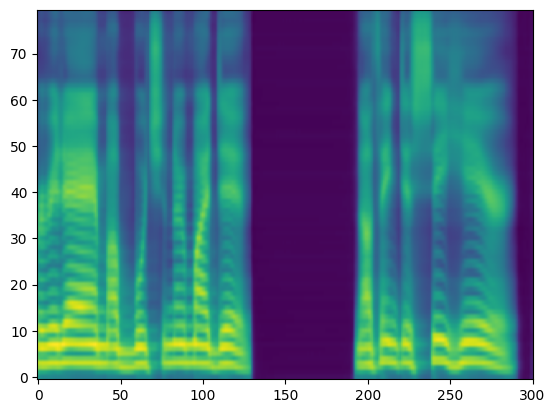

In [29]:
%matplotlib inline
plt.imshow(mel[0].detach().cpu().numpy(), origin="lower", aspect="auto")
plt.show()